# **Generate Knowledge Spaces and Calculate Content Novelty**

In [1]:
dir = 'D:/DataforPractice/ContentNovelty/'

In [2]:
import pandas as pd 
df = pd.read_csv(dir+'1_df_filtered.csv')
df

,pubid,pubyear,EU_NUTS_ID,itemtitle,abstract,period,subject
0,2010.0,1998,ES415,"Pharmacology of JB-9315, a new selective hista...",1. The histamine H-2 receptor antagonistic act...,1,Pharmacology & Pharmacy
1,2012.0,1998,NL327,Focal cerebral ischemia in the mouse: Hypother...,1. We have investigated the ability of several...,1,Pharmacology & Pharmacy
2,2013.0,1998,ES111,Pyridazine derivatives XIV. Study of the vasor...,1. For several years we have been working on t...,1,Pharmacology & Pharmacy
3,2015.0,1998,UKJ36,Structural requirements and ionic mechanism of...,1. The structural and ionic requirements for p...,1,Pharmacology & Pharmacy
4,3080.0,1998,NL230,Comparison of DNA application methods to reduc...,We compared the protection afforded by three d...,1,Immunology
...,...,...,...,...,...,...,...
26299162,46608438.0,2021,FR101,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology
26299163,46608438.0,2021,PT170,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology
26299164,46608438.0,2021,NL423,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology
26299165,46608438.0,2021,NL326,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology


# **TEST: 특정 지역/기간/주제에 대해 먼저 확인**

In [3]:
# group by (region, period, subject) and check number of unique pubid 
check = df.groupby(['EU_NUTS_ID', 'period', 'subject'])['pubid'].nunique().reset_index()
check.columns = ['EU_NUTS_ID', 'period', 'subject', 'pubid_count']
check = check.sort_values(by='pubid_count', ascending=False)
check

,EU_NUTS_ID,period,subject,pubid_count
99357,FR104,5,Physics,10350
99243,FR104,4,Physics,10158
99473,FR104,6,Physics,9587
99136,FR104,3,Physics,9301
99038,FR104,2,Physics,8669
...,...,...,...,...
51545,DEA33,4,Mathematical Methods In Social Sciences,10
96415,FI1D3,6,Mineralogy,10
138068,ITF35,6,Physical Geography,10
138081,ITF35,6,Rheumatology,10


In [4]:
df[
    (df['EU_NUTS_ID'] == 'FR104') &
    (df['period'] == 4) &
    (df['subject'] == 'Physics')
].shape

(10158, 7)

In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == "cuda":
    print(f"   Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA version: {torch.version.cuda}")
    print(f"   GPU memory allocated: {torch.cuda.memory_allocated(0)/1024**2:.1f} MB")
else:
    print("⚠ Using CPU (GPU not available)")

   Using GPU: NVIDIA GeForce RTX 5090
   CUDA version: 11.8
   GPU memory allocated: 0.0 MB


c:\ProgramData\anaconda3\envs\gpu_env\lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5090 with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


# Revised version

In [6]:
import torch, numpy as np
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

SAVE_PATH = r"D:/LLM/specter"
assert torch.cuda.is_available(), "CUDA GPU가 필요합니다!"
device = torch.device("cuda")

# 5090이면 보통 BF16 지원 → 자동 선택
use_bf16 = getattr(torch.cuda, "is_bf16_supported", lambda: False)()
dtype = torch.bfloat16 if use_bf16 else torch.float16
autocast_dtype = torch.bfloat16 if use_bf16 else torch.float16

BATCH_SIZE = 64      # VRAM 보면서 96/128까지 올려보세요
MAX_LEN = 256        # 256~384 권장

tokenizer = AutoTokenizer.from_pretrained(SAVE_PATH, use_fast=True)
model = AutoModel.from_pretrained(SAVE_PATH, torch_dtype=dtype).to(device).eval()

# ----- 데이터 준비 -----
test_key = ('FR104', 4, 'Physics')
df_test = df[
    (df['EU_NUTS_ID'] == test_key[0]) &
    (df['period'] == test_key[1]) &
    (df['subject'] == test_key[2])
].copy()

df_test['text'] = df_test['itemtitle'].fillna('') + '. ' + df_test['abstract'].fillna('')
texts = df_test['text'].tolist()

# ----- 배치 임베딩 -----
emb_list = []
with torch.inference_mode(), torch.cuda.amp.autocast(dtype=autocast_dtype):
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Embedding SPECTER (GPU @5090)"):
        batch = texts[i:i+BATCH_SIZE]
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,          # 또는 "longest"로 패딩 최소화
            truncation=True,
             max_length=MAX_LEN
        ).to(device)

        out = model(**inputs)                  # [B, T, H]
        cls = out.last_hidden_state[:, 0, :]   # CLS(<s>) 토큰
        emb_list.append(cls.detach().cpu())

embeddings = torch.vstack(emb_list).float().numpy()  # (N, 768)
df_test['embedding'] = list(embeddings)

# 센트로이드
centroid = embeddings.mean(axis=0)
print("✅ done | N:", len(df_test), "| centroid:", centroid.shape)


c:\ProgramData\anaconda3\envs\gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\AppData\Local\Temp\ipykernel_20532\4040640560.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.inference_mode(), torch.cuda.amp.autocast(dtype=autocast_dtype):
Embedding SPECTER (GPU @5090):   0%|          | 0/159 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\gpu_env\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Embedding SPECTER (GPU @5090): 100%|██████████| 159/159 [14:11:49<00:00, 321.44s/it]  

✅ done | N: 10158 | centroid: (768,)


## Original

In [20]:
import pandas as pd
from transformers import AutoModel, AutoTokenizer
import torch
from tqdm import tqdm
from sklearn.preprocessing import normalize
import numpy as np

### Load model
# SAVE_PATH = r"D:/LLM/Llama4-Scout"             
SAVE_PATH = r"D:/LLM/specter"             

tokenizer = AutoTokenizer.from_pretrained(SAVE_PATH)
model = AutoModel.from_pretrained(SAVE_PATH) #, torch_dtype=torch.float16, device_map="auto"

model.eval()

# GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)  
print(next(model.parameters()).device)  

# ---- SELECT a test group (replace with one that exists in your data) ----
test_key = ('FR104', 4, 'Physics')

# Filter to just this group
df_test = df[
    (df['EU_NUTS_ID'] == test_key[0]) &
    (df['period'] == test_key[1]) &
    
    (df['subject'] == test_key[2])
].copy()

# Combine title and abstract again for safety
# df_test['text'] = df_test['itemtitle'].fillna('') + '. ' + df_test['abstract'].fillna('')
df_test['text'] = df_test['abstract'].fillna('')


# Function to get SPECTER embedding
def get_specter_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embedding.squeeze().cpu().numpy()

# Generate embeddings
embeddings_test = []
for text in tqdm(df_test['text'], desc="Embedding test group"):
    emb = get_specter_embedding(text)
    embeddings_test.append(emb)

# Store embeddings
df_test['embedding'] = embeddings_test

# Compute centroid
test_vectors = np.stack(df_test['embedding'].to_numpy())
test_centroid = np.mean(test_vectors, axis=0)

# Output
print("\n✅ Embedding and centroid calculation complete.")
print("Number of documents in group:", len(df_test))
print("Centroid shape:", test_centroid.shape) # 768-dimensional vector
print("Sample of centroid values:", test_centroid[:10]) # the first 10 values of the 768-dimensional centroid vector


cuda
cuda:0


Embedding test group:   0%|          | 0/10158 [00:00<?, ?it/s]c:\ProgramData\anaconda3\envs\gpu_env\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Embedding test group: 100%|██████████| 10158/10158 [43:20<00:00,  3.91it/s]


✅ Embedding and centroid calculation complete.
Number of documents in group: 10158
Centroid shape: (768,)
Sample of centroid values: [-0.18076637  0.6606009   0.26348132  0.15360482  0.58678716  0.21618867
  0.98390585  0.3958102   0.7387734   0.42693582]


**Check the test data outcome**

In [13]:
# Find representative documents that are closest to the centroid
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(np.stack(df_test['embedding'].to_numpy()), test_centroid.reshape(1, -1)).flatten()
df_test['sim_to_centroid'] = sims

# print(df_test[['itemtitle', 'sim_to_centroid']].sort_values(by='sim_to_centroid', ascending=False).head(5))

# Sort and show full text with similarity
top_representative = df_test[['itemtitle', 'text', 'sim_to_centroid']].sort_values(by='sim_to_centroid', ascending=False).head(5)

# Display full text (not truncated)
for i, row in top_representative.iterrows():
    print(f"\n📘 Title: {row['itemtitle']}")
    print(f"🔢 Similarity to centroid: {row['sim_to_centroid']:.4f}")
    print(f"📝 Full text:\n{row['text']}")
    print("="*100)


📘 Title: Infrared spectroscopy of the alanine dipeptide analog in liquid water with DFT-MD. Direct evidence for P-II/beta conformations
🔢 Similarity to centroid: 0.7950
📝 Full text:
Infrared spectroscopy of the alanine dipeptide analog in liquid water with DFT-MD. Direct evidence for P-II/beta conformations. Following our previous work [J. Phys. Chem. B. Lett., 2009, 113, 10059], DFT-based molecular dynamics (DFTMD) simulations of 2-Ala peptide (i.e. Ac-Ala-NHMe dialanine peptide analog with methyl group caps at the extremities) immersed in liquid water at room temperature are reported. Our goal here is the theoretical calculation of the infrared spectrum of aqueous 2-Ala, in order to provide a definitive understanding of the average conformation adopted by this peptide in the liquid phase, taking into account solute and solvent at the same theoretical level of representation. We find that the experimental Amide I-II band predominantly results from a mixture of partially unfolded P-II

In [14]:
# Find atypical (low similarity) documents 
# print(df_test[['itemtitle', 'sim_to_centroid']].sort_values(by='sim_to_centroid').head(5))

# Sort by similarity to centroid (ascending = least similar)
least_representative = df_test[['itemtitle', 'text', 'sim_to_centroid']].sort_values(by='sim_to_centroid').head(5)

# Display full text
for i, row in least_representative.iterrows():
    print(f"\n📘 Title: {row['itemtitle']}")
    print(f"🔢 Similarity to centroid: {row['sim_to_centroid']:.4f}")
    print(f"📝 Full text:\n{row['text']}")
    print("="*100)



📘 Title: Search for new physics in the dijet mass distribution using 1 fb(-1) of pp collision data at root s=7 TeV collected by the ATLAS detector
🔢 Similarity to centroid: 0.1215
📝 Full text:
Search for new physics in the dijet mass distribution using 1 fb(-1) of pp collision data at root s=7 TeV collected by the ATLAS detector. Invariant mass distributions of jet pairs (dijets) produced in LHC proton-proton collisions at a centre-of-mass energy root s = 7 TeV have been studied using a data set corresponding to an integrated luminosity of 1.0 fb(-1) recorded in 2011 by ATLAS. Dijet masses up to similar to 4 TeV are observed in the data, and no evidence of resonance production over background is found. Limits are set at 95% C.L. for several new physics hypotheses: excited quarks are excluded for masses below 299 TeV, axigluons are excluded for masses below 3.32 TeV. and colour octet scalar resonances are excluded for masses below 1.92 TeV. (C) 2012 CERN. Published by Elsevier B.V. All

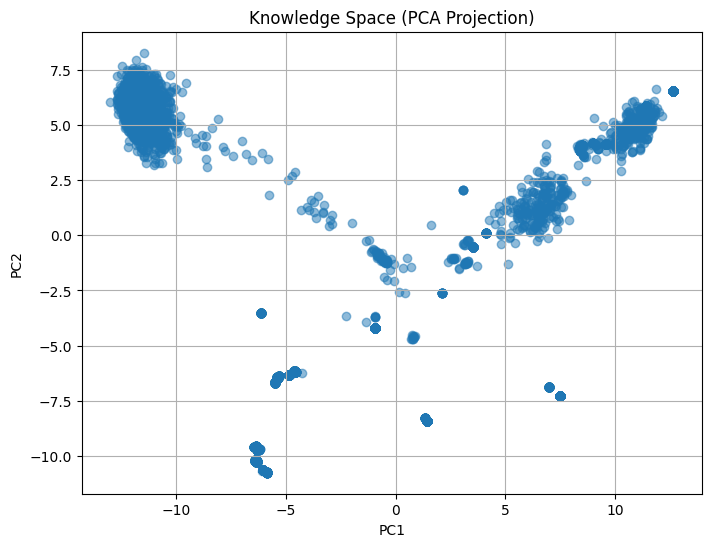

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert to matrix
X = np.stack(df_test['embedding'].to_numpy())

# Apply PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], alpha=0.5)
plt.title("Knowledge Space (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [17]:
from sklearn.metrics.pairwise import cosine_distances

# Define novelty function specific to test set
def compute_novelty_from_test_centroid(embedding):
    return cosine_distances([embedding], [test_centroid])[0][0]

# Apply to df_test
df_test['content_novelty'] = df_test['embedding'].apply(compute_novelty_from_test_centroid)
df_test

,pubid,pubyear,EU_NUTS_ID,itemtitle,abstract,period,subject,text,embedding,sim_to_centroid,content_novelty
3700443,7272841.0,2010,FR104,Measurement of the W -&gt; lv and Z/gamma* -&g...,First measurements of the W -&gt; lv and Z/gam...,4,Physics,Measurement of the W -&gt; lv and Z/gamma* -&g...,"[0.08509567, 0.22845384, 0.5161562, 0.8057313,...",0.716947,0.283053
3700832,7273465.0,2012,FR104,Bose-Einstein condensation and thermalization ...,"In ultra-relativistic heavy ion collisions, th...",4,Physics,Bose-Einstein condensation and thermalization ...,"[-0.31213218, 0.11312702, 0.90445614, -0.57069...",0.677218,0.322782
3701553,7280028.0,2010,FR104,Implementation of the Wigner-Boltzmann transpo...,"In this paper, we detail the main numerical is...",4,Physics,Implementation of the Wigner-Boltzmann transpo...,"[-0.3033904, 1.1299967, 0.7965871, -0.30040634...",0.710322,0.289678
3711165,7319632.0,2010,FR104,Excitation of physical vacuum through (p)over-...,In this work we discuss the interest of measur...,4,Physics,Excitation of physical vacuum through (p)over-...,"[0.02744734, 0.4492751, -0.89587986, 0.1412485...",0.701354,0.298646
3711193,7319648.0,2010,FR104,Chameleon induced atomic afterglow,The chameleon is a scalar field whose mass dep...,4,Physics,Chameleon induced atomic afterglow. The chamel...,"[-0.50158817, 0.69420946, -0.09366651, -0.2169...",0.714583,0.285417
...,...,...,...,...,...,...,...,...,...,...,...
19521873,35607388.0,2012,FR104,Combined search for the Standard Model Higgs b...,A combined search for the Standard Model Higgs...,4,Physics,Combined search for the Standard Model Higgs b...,"[-0.3772825, 0.46729392, 0.77305, -0.81392765,...",0.692386,0.307614
19522547,35607699.0,2011,FR104,Measurement of W gamma and Z gamma production ...,We present studies of W and Z bosons with asso...,4,Physics,Measurement of W gamma and Z gamma production ...,"[-0.6587365, 0.45275998, 1.1128008, -0.6479068...",0.687341,0.312659
19522919,35607946.0,2012,FR104,Search for a heavy top-quark partner in final ...,The results of a search for direct pair produc...,4,Physics,Search for a heavy top-quark partner in final ...,"[0.1468709, 0.45974216, 0.9624506, 0.11164745,...",0.725297,0.274703
20524983,37356118.0,2013,FR104,Windowless thin solid-hydrogen target: CHyMENE,We report on the production of a windowless pu...,4,Physics,Windowless thin solid-hydrogen target: CHyMENE...,"[0.5109141, 0.8828666, -0.3454781, 0.5050546, ...",0.665208,0.334792


In [18]:
# Inspect most novel documents

# Sort by novelty (descending = most novel)
# df_test.sort_values('content_novelty', ascending=False)[['itemtitle', 'content_novelty']].head(5)

top_novel = df_test.sort_values('content_novelty', ascending=False).head(5)
for i, row in top_novel.iterrows():
    print(f"\n📘 Title: {row['itemtitle']}")
    print(f"📏 Content novelty (cosine distance): {row['content_novelty']:.4f}")
    print(f"📝 Full text:\n{row['text']}")
    print("="*100)


📘 Title: Search for new physics in the dijet mass distribution using 1 fb(-1) of pp collision data at root s=7 TeV collected by the ATLAS detector
📏 Content novelty (cosine distance): 0.8785
📝 Full text:
Search for new physics in the dijet mass distribution using 1 fb(-1) of pp collision data at root s=7 TeV collected by the ATLAS detector. Invariant mass distributions of jet pairs (dijets) produced in LHC proton-proton collisions at a centre-of-mass energy root s = 7 TeV have been studied using a data set corresponding to an integrated luminosity of 1.0 fb(-1) recorded in 2011 by ATLAS. Dijet masses up to similar to 4 TeV are observed in the data, and no evidence of resonance production over background is found. Limits are set at 95% C.L. for several new physics hypotheses: excited quarks are excluded for masses below 299 TeV, axigluons are excluded for masses below 3.32 TeV. and colour octet scalar resonances are excluded for masses below 1.92 TeV. (C) 2012 CERN. Published by Elsevi

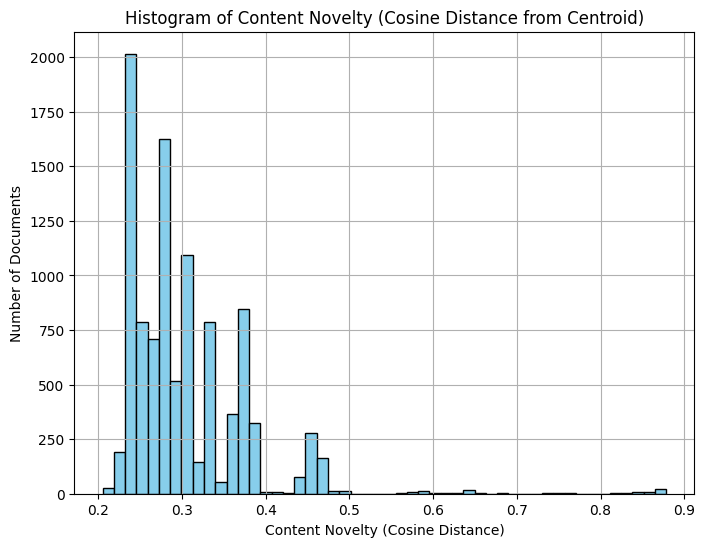

In [19]:
import matplotlib.pyplot as plt

# Drop any NaNs just in case
novelty_scores = df_test['content_novelty'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(novelty_scores, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Content Novelty (Cosine Distance from Centroid)")
plt.xlabel("Content Novelty (Cosine Distance)")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()

# **Main Analysis**
- Apply the code below to the entire dataset (1_df_filtered.csv)

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.preprocessing import normalize

### Load model
# SAVE_PATH = r"D:/LLM/Llama4-Scout"             
SAVE_PATH = r"D:/LLM/specter"             

tokenizer = AutoTokenizer.from_pretrained(SAVE_PATH)
model = AutoModel.from_pretrained(SAVE_PATH, torch_dtype=torch.float16, device_map="auto") #, torch_dtype=torch.float16, device_map="auto"

model.eval()

# GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Combine title + abstract into one string
df['text'] = df['itemtitle'].fillna('') + '. ' + df['abstract'].fillna('')

# Function to get embeddings using SPECTER
def get_specter_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embedding.squeeze().cpu().numpy()

# Create column to store embeddings
embeddings = []

# Loop with tqdm
for text in tqdm(df['text'], desc="Embedding documents"):
    emb = get_specter_embedding(text)
    embeddings.append(emb)

# Store embeddings as numpy array
df['embedding'] = embeddings

# --- Group by Region, Period, Subject to form Knowledge Spaces ---
# create a dict like: {(region, period, subject): [list of vectors]}

from collections import defaultdict
import numpy as np

knowledge_spaces = defaultdict(list)

for _, row in df.iterrows():
    key = (row['EU_NUTS_ID'], row['period'], row['subject'])
    knowledge_spaces[key].append(row['embedding'])

# Compute centroids for each group
centroids = {k: np.mean(vectors, axis=0) for k, vectors in knowledge_spaces.items()}

knowledge_spaces.to_csv('2_knowledge_spaces.csv', index=False)
centroids.to_csv('2_centroids.csv', index=False)

In [ ]:
knowledge_spaces.to_csv('2_knowledge_spaces.csv', index=False)

# Key: tuple → (EU_NUTS_ID, period, subject)
# Value: list of NumPy arrays → embeddings of all papers in that region/period/field group

In [ ]:
centroids.to_csv('2_centroids.csv', index=False)

# This has the same keys as knowledge_spaces, but the values are single mean vectors (centroids):

**Compute content novelty as the cosine distance between each paper's embedding and the centroid of its region-period-subject group (i.e., knowledge space centroid)**

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# Define function to compute cosine distance from centroid
def compute_novelty(row):
    key = (row['EU_NUTS_ID'], row['period'], row['subject'])
    centroid = centroids.get(key)
    if centroid is None:
        return np.nan
    return cosine_distances([row['embedding']], [centroid])[0][0]

# Apply function to each row
df['content_novelty'] = df.apply(compute_novelty, axis=1)

In [ ]:
# Check a sample of novelty values
df[['EU_NUTS_ID', 'period', 'subject', 'content_novelty']].head()

# Distribution of novelty
df['content_novelty'].hist(bins=50)

# Check content novelty

In [6]:
import pandas as pd
df_parquet = pd.read_parquet(dir +'3_external_with_novelty.parquet') # 2_knowledge_spaces.parquet
df_parquet.to_csv(dir+'3_external_with_novelty.csv')
df_parquet.head()

,ID,EU_NUTS_ID,period,subject,pubid,content_novelty
0,1-ES415-Pharmacology & Pharmacy,ES415,1,Pharmacology & Pharmacy,47915.0,0.245345
1,1-ES415-Pharmacology & Pharmacy,ES415,1,Pharmacology & Pharmacy,84607.0,0.286929
2,1-ES415-Pharmacology & Pharmacy,ES415,1,Pharmacology & Pharmacy,323177.0,0.186295
3,1-ES415-Pharmacology & Pharmacy,ES415,1,Pharmacology & Pharmacy,459460.0,0.272767
4,1-ES415-Pharmacology & Pharmacy,ES415,1,Pharmacology & Pharmacy,542349.0,0.198274
